# Analyzing Sentiment in Glassdoor Employer Reviews

In [1]:
import os
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch

import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

### Parquet File as DataFrame

In [3]:
data_path = "data/glassdoor/rev-anon.parquet"

In [4]:
%time df = pd.read_parquet(data_path)

Wall time: 25.6 s


In [5]:
df

,index,pros,cons,feedback
0,1,The people to work with,11-14 hour shifts. And always understaff.,Hire more hardworking people and schedule fair...
1,2,A company in rapid growth and expansion,Extensive changes in upper level management ov...,"Ensure a solid foundation of training, allowan..."
2,3,"Get to know the industry, profit margins, etc....","Very, very unorganized on every level, stock i...","Take care of your employees, better."
3,4,"Friendly people, good company values",Layoff of long term employees - losing years o...,None
4,5,"nice organized project, great boss.",none that i could see. mostly worked remote.,None
...,...,...,...,...
6754231,6754232,"If you live in Galveston, you'll be close to ...",Horrible place to work. They do not care about...,None. They will never improve.
6754232,6754233,good working environment and good insurance pa...,"not flexible working hour, needs a better man...",None
6754233,6754234,"Small pockets of honest, hardworking employees...",Leadership is a train wreck. A lot of clique-i...,Realize that without the employees in all loca...
6754234,6754235,Good hard work and some very good people,Long hours with little compensation,None


In [7]:
df.iloc[6754235]['pros']

'Gained valuable experience in the field with products and customers. Really enjoyed being able to spend time with and learn from the higher ups in the company.'

In [22]:
# replace None with blank space in all columns
df.fillna("", inplace=True)

In [23]:
# replace newlines with periods since they nearly always indicate a new idea
df.replace(r'\n\n',  '. ', regex=True, inplace=True)
df.replace(r'\r\n',  '. ', regex=True, inplace=True)
df.replace('(\r|\n)',  '. ', regex=True, inplace=True)
df.replace(' - ',  ' ', inplace=True)
df.replace('...',  '. ', inplace=True)
df.replace('..',  '. ', inplace=True)
df.replace('..',  '.', inplace=True)

In [49]:
df

,pros,cons,feedback,review_num
0,[The people to work with],"[11-14 hour shifts., And always understaff.]",[Hire more hardworking people and schedule fai...,0
1,[A company in rapid growth and expansion],[Extensive changes in upper level management o...,"[Ensure a solid foundation of training, allowa...",1
2,"[Get to know the industry, profit margins, etc...","[Very, very unorganized on every level, stock ...","[Take care of your employees, better.]",2
3,"[Friendly people, good company values]",[Layoff of long term employees - losing years ...,[],3
4,"[nice organized project, great boss.]","[none that i could see., mostly worked remote.]",[],4
...,...,...,...,...
6754231,"[If you live in Galveston, you'll be close to...","[Horrible place to work., They do not care abo...","[None., They will never improve.]",6754231
6754232,[good working environment and good insurance p...,"[not flexible working hour, needs a better ma...",[],6754232
6754233,"[Small pockets of honest, hardworking employee...","[Leadership is a train wreck., A lot of clique...",[Realize that without the employees in all loc...,6754233
6754234,[Good hard work and some very good people],[Long hours with little compensation],[],6754234


In [50]:
df.iloc[1577]

pros          [Excellent coworkers, majority of managers are...
cons          [Some managers play favorites., Far too much w...
feedback      [Stop playing favorites., Also, take the time ...
review_num                                                 1577
Name: 1577, dtype: object

# Sentence Tokenization

In [41]:
import nltk
# nltk.download('punkt')

In [42]:
def tokenize_sentences(df, target_column, new_column=None, drop_target=False):
    if new_column is None:
        new_column = target_column
    print("starting sentence tokenization on", target_column)
    start = time.time()
    df[new_column] = df[target_column].apply(nltk.tokenize.sent_tokenize)
    if drop_target:
        df.drop(columns=[target_column], inplace=True)
    df.replace("[]", "", inplace=True)
    print("sentence tokenization on", target_column, (time.time() - start), "s")

In [43]:
tokenize_sentences(df, "pros", "stoken_pros", drop_target=True)

starting sentence tokenization on pros
sentence tokenization on pros 352.374892950058 s


In [44]:
tokenize_sentences(df, "cons", "stoken_cons", drop_target=True)

starting sentence tokenization on cons
sentence tokenization on cons 424.8681631088257 s


In [45]:
tokenize_sentences(df, "feedback", "stoken_feedback", drop_target=True)

starting sentence tokenization on feedback
sentence tokenization on feedback 225.60872602462769 s


In [46]:
columns={
    "stoken_pros"     : "pros", 
    "stoken_cons"     : "cons",
    "stoken_feedback" : "feedback"  
}

df.rename(columns=columns, inplace=True)

In [47]:
df

,pros,cons,feedback
0,[The people to work with],"[11-14 hour shifts., And always understaff.]",[Hire more hardworking people and schedule fai...
1,[A company in rapid growth and expansion],[Extensive changes in upper level management o...,"[Ensure a solid foundation of training, allowa..."
2,"[Get to know the industry, profit margins, etc...","[Very, very unorganized on every level, stock ...","[Take care of your employees, better.]"
3,"[Friendly people, good company values]",[Layoff of long term employees - losing years ...,[]
4,"[nice organized project, great boss.]","[none that i could see., mostly worked remote.]",[]
...,...,...,...
6754231,"[If you live in Galveston, you'll be close to...","[Horrible place to work., They do not care abo...","[None., They will never improve.]"
6754232,[good working environment and good insurance p...,"[not flexible working hour, needs a better ma...",[]
6754233,"[Small pockets of honest, hardworking employee...","[Leadership is a train wreck., A lot of clique...",[Realize that without the employees in all loc...
6754234,[Good hard work and some very good people],[Long hours with little compensation],[]


In [48]:
df['review_num'] = df.index

# Clause Tokenization
No suitable solution for this yet. Come back to it later...

In [12]:
# from sent_to_clauses import *

# Saving Tokenized Data to JSON

In [16]:
save_path = "data/glassdoor/glassdoor_stoken.json.gz"

In [17]:
start = time.time()
df.to_json(save_path, orient="records", lines=True)
print("json save time", (time.time() - start), "s")

json save time 271.5213041305542 s


In [3]:
start = time.time()
df2 = pd.read_json(save_path, lines=True)
print("json load time", (time.time() - start), "s")

json load time 85.31675958633423 s


In [6]:
df2

,pros,cons,feedback
0,[The people to work with],"[11-14 hour shifts., And always understaff.]",[Hire more hardworking people and schedule fai...
1,[A company in rapid growth and expansion],[Extensive changes in upper level management o...,"[Ensure a solid foundation of training, allowa..."
2,"[Get to know the industry, profit margins, etc...","[Very, very unorganized on every level, stock ...","[Take care of your employees, better.]"
3,"[Friendly people, good company values]",[Layoff of long term employees - losing years ...,[]
4,"[nice organized project, great boss.]","[none that i could see., mostly worked remote.]",[]
...,...,...,...
6754231,"[If you live in Galveston, you'll be close to...","[Horrible place to work., They do not care abo...","[None., They will never improve.]"
6754232,[good working environment and good insurance p...,"[not flexible working hour, needs a better ma...",[]
6754233,"[Small pockets of honest, hardworking employee...","[Leadership is a train wreck., A lot of clique...",[Realize that without the employees in all loc...
6754234,[Good hard work and some very good people],[Long hours with little compensation],[]


## Split Data by Sentence

In [51]:
df['review_num'] = df.index

In [52]:
df_pros = df[['review_num', 'pros']].copy()
df_pros['type'] = 1
df_pros = df_pros.explode('pros')
df_pros.rename(columns={"pros" : "text"}, inplace=True)

In [53]:
df_cons = df[['review_num', 'cons']].copy()
df_cons['type'] = 2
df_cons = df_cons.explode('cons')
df_cons.rename(columns={"cons" : "text"}, inplace=True)

In [54]:
df_feedback = df[['review_num', 'feedback']].copy()
df_feedback['type'] = 3
df_feedback = df_feedback.explode('feedback')
df_feedback.rename(columns={"feedback" : "text"}, inplace=True)

In [55]:
new_df = pd.concat([df_pros, df_cons, df_feedback])

In [27]:
new_df.review_num.max()

6754235

In [141]:
len(new_df)

43136693

In [56]:
new_df.dropna(axis=0, how='any', inplace=True)

In [144]:
len(new_df)

40279470

In [57]:
new_df.sort_index(inplace=True)

In [58]:
new_df

,review_num,text,type
0,0,The people to work with,1
0,0,Hire more hardworking people and schedule fair...,3
0,0,And always understaff.,2
0,0,11-14 hour shifts.,2
1,1,"Ensure a solid foundation of training, allowan...",3
...,...,...,...
6754234,6754234,Long hours with little compensation,2
6754235,6754235,Really enjoyed being able to spend time with a...,1
6754235,6754235,Gained valuable experience in the field with p...,1
6754235,6754235,If you don't like working outside or getting d...,2


### Saving Split Sentence Data

In [59]:
save_path = "data/glassdoor/glassdoor_split_stoken.parquet"

In [60]:
new_df.to_parquet(save_path)

In [32]:
start = time.time()
new_df.to_json(save_path, orient="records", lines=True)
print("json save time", (time.time() - start), "s")

json save time 358.071496963501 s


In [5]:
start = time.time()
df = pd.read_json(save_path, lines=True)
print("json save time", (time.time() - start), "s")

json save time 1130.7960994243622 s


In [61]:
df

,review_num,text,type
0,0,The people to work with,1
0,0,Hire more hardworking people and schedule fair...,3
0,0,And always understaff.,2
0,0,11-14 hour shifts.,2
1,1,"Ensure a solid foundation of training, allowan...",3
...,...,...,...
6754234,6754234,Long hours with little compensation,2
6754235,6754235,Really enjoyed being able to spend time with a...,1
6754235,6754235,Gained valuable experience in the field with p...,1
6754235,6754235,If you don't like working outside or getting d...,2


# Topic Modeling

In [5]:
import joblib
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [7]:
n_samples = 1000000
n_features = 1000
n_components = 8
n_top_words = 10

max_iter = 1000

In [35]:
df_flat = list(itertools.chain(*df2.head(n_samples).values)) # @1m = 5,971,134
# df_flat = list(itertools.chain(*df2.values)) # 40,279,470
df_flat = list(itertools.chain(*df_flat))

In [36]:
len(df_flat)

40279470

In [10]:
from sklearn.feature_extraction import text

In [48]:
blacklist_words = [
    "excellent","good","great","like",
    "nice","better","pretty","decent",
    "bad","poor","don","stop",
    "really","lot","make","doing"  
]

In [49]:
my_stopwords = text.ENGLISH_STOP_WORDS.union(blacklist_words)

## Exploring Topic Model Options

### TFIDF

In [50]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2,
                                   max_features=n_features,
                                   stop_words=my_stopwords)
start = time.time()
tfidf = tfidf_vectorizer.fit_transform(df_flat['text'])
print("TfidfVectorizer done in %0.3fs." % (time.time() - start))

Extracting tf-idf features for NMF...
TfidfVectorizer done in 44.445s.


### NMF

In [51]:
# save tfidf vectorizer
joblib.dump(tfidf_vectorizer, "assets/glassdoor/tfidf_vectorizer.jl")

['assets/glassdoor/tfidf_vectorizer.jl']

In [52]:
# load tfidf vectorizer
tfidf_vectorizer = joblib.load("assets/glassdoor/tfidf_vectorizer.jl")

#### NMF | Frobenius norm

In [53]:
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

nmf_fro = NMF(n_components=n_components, 
              max_iter=max_iter,
              random_state=1,
              alpha=.1, 
              l1_ratio=.5,
              verbose=True)

start = time.time()
nmf_fro.fit(tfidf)
print("done in %0.3fs." % (time.time() - start))

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=10000000 and n_features=1000...
violation: 1.0
violation: 0.3502773757920608
violation: 0.07812393774422169
violation: 0.031164465673373016
violation: 0.01963733627035737
violation: 0.015156254298488757
violation: 0.013240268167404824
violation: 0.012458300830801515
violation: 0.012123333251036848
violation: 0.011982835200335416
violation: 0.01192031952792993
violation: 0.011890205589669975
violation: 0.011872781212513575
violation: 0.011861265995368447
violation: 0.011852510276732547
violation: 0.011845180222715466
violation: 0.01183814980887401
violation: 0.01183120226736689
violation: 0.011824258445802194
violation: 0.01181721653188438
violation: 0.011810042230348266
violation: 0.011802655096931496
violation: 0.011794991123559835
violation: 0.011786993757748446
violation: 0.01177881517259099
violation: 0.011770337161762635
violation: 0.011761431268944427
violation: 0.01175228268991173
violation: 0.011742952892719

violation: 0.005432216202101382
violation: 0.005404039789400507
violation: 0.005375963210129291
violation: 0.0053479846954644595
violation: 0.005320104347122009
violation: 0.005292319036859201
violation: 0.005264633648984951
violation: 0.005237049024563782
violation: 0.00520956814491719
violation: 0.005182190274082075
violation: 0.0051549105645534235
violation: 0.005127727455592917
violation: 0.005100642444435155
violation: 0.0050736585275240175
violation: 0.005046777246531225
violation: 0.005020003584107115
violation: 0.004993324996185632
violation: 0.004966761813980959
violation: 0.0049402890422812346
violation: 0.004913915762616216
violation: 0.004887645479482979
violation: 0.004861504810608385
violation: 0.004835447629379116
violation: 0.004809484038001981
violation: 0.0047836237447486905
violation: 0.00475786978245525
violation: 0.004732216220108236
violation: 0.004706662356235459
violation: 0.0046812132366460864
violation: 0.004655867954543649
violation: 0.0046306272794792765
vio

violation: 0.0012133182324710235
violation: 0.0012056028730693831
violation: 0.0011979343031326797
violation: 0.00119031211997177
violation: 0.0011827361003021687
violation: 0.0011752064032416957
violation: 0.0011677230124681548
violation: 0.0011602838702574954
violation: 0.0011528901157953542
violation: 0.0011455415718955332
violation: 0.001138237334427942
violation: 0.0011309790049943715
violation: 0.0011237646120964698
violation: 0.0011165934679454122
violation: 0.0011094661487260598
violation: 0.0011023819503724313
violation: 0.0010953420025221082
violation: 0.0010883443461094076
violation: 0.0010813893826875673
violation: 0.0010744772805259802
violation: 0.0010676071840226983
violation: 0.001060779110506365
violation: 0.0010539929653100245
violation: 0.0010472483652456776
violation: 0.0010405452445362716
violation: 0.0010338833588071892
violation: 0.001027262649483782
violation: 0.001020682353303127
violation: 0.0010141424130340575
violation: 0.0010076427054681878
violation: 0.001

violation: 0.00024098318856963038
violation: 0.00023940268326635026
violation: 0.00023783253292406054
violation: 0.00023627268876579664
violation: 0.00023472306855935881
violation: 0.00023318358591506102
violation: 0.00023165417848250962
violation: 0.00023013477701863078
violation: 0.00022862532588670888
violation: 0.0002271258396274884
violation: 0.000225636213106177
violation: 0.0002241562365069109
violation: 0.0002226859588243513
violation: 0.00022122531940527512
violation: 0.00021977425239208
violation: 0.00021833270936363707
violation: 0.00021690060265572075
violation: 0.00021547789030921887
violation: 0.00021406450481883428
violation: 0.0002126603858967762
violation: 0.00021126548881395153
violation: 0.0002098797204195678
violation: 0.0002085030354840829
violation: 0.00020713538698654099
violation: 0.0002057767113162539
violation: 0.0002044269477401409
violation: 0.0002030860322952235
violation: 0.00020175391497656215
violation: 0.00020043054961623992
violation: 0.000199115855562

In [54]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_fro, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic 0: work place environment life balance hard fun team home schedule
Topic 1: company culture growing growth small working years opportunities grow large
Topic 2: pay low competitive average little rate raises attention hours high
Topic 3: people working friendly hire smart care culture worked fun know
Topic 4: management upper team staff senior communication new training needs lack
Topic 5: employees care treat listen respect managers new customers value training
Topic 6: benefits health salary environment 401k package compensation insurance competitive employee
Topic 7: time job hours long working flexible training schedule day just


In [55]:
# save nmf_fro
joblib.dump(nmf_fro, "assets/glassdoor/nmf_fro.jl")

['assets/glassdoor/nmf_fro.jl']

In [56]:
# load nmf_fro
nmf_fro = joblib.load("assets/glassdoor/nmf_fro.jl")

#### NMF | Kullback-Leibler divergence

In [57]:
print("Fitting the NMF model (Kullback-Leibler divergence) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

nmf_KL = NMF(n_components=n_components, 
             beta_loss='kullback-leibler', 
             solver='mu',
             max_iter=max_iter,
             random_state=1,
             alpha=.1, 
             l1_ratio=.5,
             verbose=True)

start = time.time()
nmf_KL.fit(tfidf)
print("done in %0.3fs." % (time.time() - start))

Fitting the NMF model (Kullback-Leibler divergence) with tf-idf features, n_samples=10000000 and n_features=1000...
Epoch 10 reached after 50.475 seconds, error: 8487.658387
Epoch 20 reached after 98.581 seconds, error: 8468.247825
Epoch 30 reached after 147.608 seconds, error: 8463.630706
Epoch 40 reached after 196.858 seconds, error: 8461.399286
Epoch 50 reached after 245.669 seconds, error: 8460.301346
Epoch 60 reached after 294.281 seconds, error: 8459.583487
done in 321.661s.


In [58]:
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_KL, tfidf_feature_names, n_top_words)


Topics in NMF model (generalized Kullback-Leibler divergence):
Topic 0: work environment place hard life culture office balance fun learn
Topic 1: company new growth opportunities business say sales career opportunity years
Topic 2: pay low high salary little competitive raises paid overtime turnover
Topic 3: people friendly workers hire coworkers location smart jobs meet helpful
Topic 4: management staff team leadership communication upper support lack level needs
Topic 5: employees just care need managers customers know want help way
Topic 6: benefits employee free family health compensation food insurance amazing vacation
Topic 7: time job hours working long flexible day think cons training


In [59]:
# save nmf_KL
joblib.dump(nmf_KL, "assets/glassdoor/nmf_KL.jl")

['assets/glassdoor/nmf_KL.jl']

In [60]:
# load nmf_KL
nmf_KL = joblib.load("assets/glassdoor/nmf_KL.jl")

### CountVectorizer

In [61]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=n_features,
                                stop_words=my_stopwords)
start = time.time()
tf = tf_vectorizer.fit_transform(df_flat['text'])
print("CountVectorizer done in %0.3fs." % (time.time() - start))

Extracting tf features for LDA...
CountVectorizer done in 44.095s.


In [62]:
# save tf vectorizer
joblib.dump(tf_vectorizer, "assets/glassdoor/tf_vectorizer.jl")

['assets/glassdoor/tf_vectorizer.jl']

In [63]:
# load tf vectorizer
tf_vectorizer = joblib.load("assets/glassdoor/tf_vectorizer.jl")

### LDA

In [64]:
# Fit the LDA model
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=1,
                                verbose=1)

start = time.time()
lda.fit(tf)
print("done in %0.3fs." % (time.time() - start))

Fitting LDA models with tf features, n_samples=10000000 and n_features=1000...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done in 1726.940s.


In [65]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic 0: environment managers work employee feel management going easy clients making
Topic 1: employees management company training care leadership experience manager money lack
Topic 2: pay hours staff new working high flexible workers customers opportunities
Topic 3: work people just hard want fun think working career schedule
Topic 4: company culture long business office people years sales opportunity friendly
Topic 5: work benefits team place life need best help people things
Topic 6: time know day little worked pay year change days does
Topic 7: job low learn family needs customer time corporate atmosphere product


In [66]:
# save nmf_KL
joblib.dump(nmf_KL, "assets/glassdoor/lda.jl")

['assets/glassdoor/lda.jl']

In [67]:
# load nmf_KL
lda = joblib.load("assets/glassdoor/lda.jl")

## Assigning Topics

### nmf_fro

In [56]:
# Topics in NMF model (Frobenius norm):
# Work/Life Balance : work life balance environment place hours hard flexible home fun
# Culture           : great benefits place environment culture team job workers experience coworkers
# Experience        : good benefits job experience salary environment training pretty health workers
# Management        : management upper team poor staff senior new communication bad training
# Growth Potential  : company culture growing growth working small years like grow opportunities
# Coworkers         : people nice working don friendly really like lot hire smart
# Hours             : pay low hours benefits decent time better competitive long flexible
# Respectfulness    : employees time care don like job listen treat better make

nmf_fro_topic_labels = [
    "Work/Life Balance",
    "Culture",          
    "Experience",       
    "Management",             
    "Growth Potential", 
    "Coworkers",        
    "Hours",       
    "Respect",                   
]

In [98]:
idx = slice(20,30)

In [99]:
nmf_fro_topic_scores = nmf_fro.transform(tf[idx])
nmf_fro_topic_assignments = np.argmax(nmf_fro_topic_scores, axis=1)

violation: 1.0
violation: 0.031913431078919204
violation: 0.00022574799913165333
violation: 2.050974742194805e-06
Converged at iteration 5


In [100]:
nmf_fro_data = zip(list(map(lambda x: nmf_fro_topic_labels[x], nmf_fro_topic_assignments)), df_flat[idx])
df_nmf_fro   = pd.DataFrame(nmf_fro_data, columns=["text", "label"])
df_nmf_fro

,text,label
0,Coworkers,I do not think I can find cons to working here.
1,Work/Life Balance,"just work, work and you will be on the way up the ladder soon"
2,Management,how does one join management?
3,Coworkers,I think that is a question a lot of people may have
4,Culture,"Great customers, co-workers, and money."
5,Management,The restaurant is organized and clean.
6,Management,The management was not consistent with their rules and play favorites.
7,Culture,The new uniforms are not great.
8,Hours,Nothing .. besides a pay check
9,Management,Unprofessional .


### nmf_KL

In [101]:
# Topics in NMF model (generalized Kullback-Leibler divergence):
# Work/Life Balance : work environment place good hard life office flexible balance fun
# Culture           : great team staff leadership experience workers coworkers amazing support atmosphere
# Compensation      : good benefits job training employee bad salary free industry start
# Management        : management think new business way communication lack change upper need
# Growth Potential  : company culture growth cons opportunities years growing opportunity small grow
# Coworkers         : people working really nice lot doing know just worked best
# Hours             : pay time hours better long day don low high little
# Customers         : employees care like managers customers stop listen treat don continue

nmf_KL_topic_labels = [
    "Work/Life Balance",       
    "Culture",         
    "Compensation",             
    "Management",
    "Growth Potential", 
    "Coworkers",          
    "Hours",     
    "Customers"    
]

In [102]:
idx = slice(20,30)

In [103]:
nmf_KL_topic_scores = nmf_KL.transform(tf[idx])
nmf_KL_topic_assignments = np.argmax(nmf_KL_topic_scores, axis=1)

Epoch 10 reached after 0.000 seconds, error: 14.571557
Epoch 20 reached after 0.000 seconds, error: 14.570800


In [104]:
nmf_KL_data = zip(list(map(lambda x: nmf_KL_topic_labels[x], nmf_KL_topic_assignments)), df_flat[idx])
df_nmf_KL   = pd.DataFrame(nmf_KL_data, columns=["text", "label"])
df_nmf_KL

,text,label
0,Growth Potential,I do not think I can find cons to working here.
1,Management,"just work, work and you will be on the way up the ladder soon"
2,Management,how does one join management?
3,Coworkers,I think that is a question a lot of people may have
4,Culture,"Great customers, co-workers, and money."
5,Work/Life Balance,The restaurant is organized and clean.
6,Management,The management was not consistent with their rules and play favorites.
7,Culture,The new uniforms are not great.
8,Hours,Nothing .. besides a pay check
9,Management,Unprofessional .


### lda

In [88]:
# Topics in LDA model:
# Management        : like employees lot better managers make care need high management
# Experience        : company job don experience employee people just business best know
# Hours             : pay working time hours day long years sales low customers
# Culture           : work good management environment hard people culture flexible fun friendly
# Growth Potential  : employees company new place training opportunities growth things learn think
# Compensation      : great benefits work team people good nice pay workers going
# Coworkers         : staff office really want little support free management come amazing
# Work/Life Balance : work life doing leadership balance opportunity manager help times change

lda_topic_labels = [
    "Management",       
    "Experience",         
    "Hours",             
    "Culture",
    "Growth Potential", 
    "Compensation",          
    "Coworkers",     
    "Work/Life Balance",       
]

In [105]:
idx = slice(20,30)

In [106]:
lda_topic_scores = lda.transform(tf[idx])
lda_topic_assignments = np.argmax(lda_topic_scores, axis=1)

Epoch 10 reached after 0.005 seconds, error: 14.571557
Epoch 20 reached after 0.008 seconds, error: 14.570800


In [107]:
lda_data = zip(list(map(lambda x: lda_topic_labels[x], lda_topic_assignments)), df_flat[idx])
lda_KL   = pd.DataFrame(lda_data, columns=["text", "label"])
lda_KL

,text,label
0,Growth Potential,I do not think I can find cons to working here.
1,Culture,"just work, work and you will be on the way up the ladder soon"
2,Culture,how does one join management?
3,Compensation,I think that is a question a lot of people may have
4,Experience,"Great customers, co-workers, and money."
5,Management,The restaurant is organized and clean.
6,Culture,The management was not consistent with their rules and play favorites.
7,Experience,The new uniforms are not great.
8,Coworkers,Nothing .. besides a pay check
9,Culture,Unprofessional .


Judging from manually reviewing the first 30 assignments from each topic model, NMF trained with a Frobenius norm seems to be the best so I'll continue with that for now.

In [25]:
load_path = "data/glassdoor/glassdoor_split_stoken.json"

In [26]:
start = time.time()
data_loader = pd.read_json(load_path, lines=True, chunksize=100)
print("json load time", (time.time() - start), "s")

json load time 0.01511526107788086 s


In [23]:
def drop_short_sents(df, column, num_char):
    df.drop(df[df[column].map(len) < num_char].index, inplace=True)

In [16]:
def assign_topic(df, column, vectorizer, topic_model):
    vectorized = vectorizer.transform(df[column])
    topic_scores = topic_model.transform(vectorized)
    df['topic'] = np.argmax(topic_scores, axis=1)

In [17]:
def append_df_to_JSON(file, df):
    json_df = df.to_json(
        # path_or_buf=file_path,
        orient='records',
        lines=True
    )
    with open(file, 'a', encoding='utf8') as f:
        f.write(json_df)
        f.write("\n")

In [28]:
save_path = "data/glassdoor/glassdoor_split_stoken_topics.json"

In [ ]:
i=0
for next_df in data_loader:
    drop_short_sents(next_df, 'text', 3)
    assign_topic(next_df, 'text', tfidf_vectorizer, nmf_fro)
    append_df_to_JSON(file_path, next_df)
    i+=1
    if i==3:
        break

In [39]:
new_df = pd.read_json(save_path, lines=True, chunksize=100)
next_df = next(iter(new_df))

In [40]:
next_df

,review_num,type,topic,text
0,0,1,5,The people to work with
1,0,3,5,Hire more hardworking people and schedule fair...
2,0,2,0,And always understaff.
3,0,2,6,11-14 hour shifts.
4,1,2,3,Extensive changes in upper level management ov...
...,...,...,...,...
95,20,1,2,Some good people work there.
96,20,3,3,Top layer may have great ideas and the lower g...
97,21,2,6,"No vacation, or sick time pay.. No paid vacat..."
98,21,1,6,Union position.


# Sentiment Pipeline

In [11]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [12]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

# Previously tried ######################
# "roberta-base"                                                   | not sentiment analysis
# "roberta-large-mnli"                                             | not sentiment analysis
# "distilbert-base-uncased-finetuned-sst-2-english"                | works!!! NEGATIVE, POSITIVE
# "sshleifer/tiny-distilbert-base-uncased-finetuned-sst-2-english" | fail
# "textattack/roberta-base-SST-2"                                  | works!!! LABEL_0, LABEL_1
# "distilbert-base-uncased"                                        | fail
# "distilbert-base-cased"                                          | fail

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [14]:
classifier = pipeline(
    task='sentiment-analysis',
    model=model, 
    tokenizer=tokenizer,
    device=-1,
    framework='pt',
    return_all_scores=False
)

In [15]:
# classifier.model

In [16]:
# classifier('what is the time?')

In [ ]:
save_path = "data/amazon/by_category/preprocessed"

column_order = ['category_id', 
                'overall', 
                'star_sentiment', 
                'reviewText', 
                'summary', 
                'num_words', 
                'polarity']

category_id = 0

error_counter = 0

for file_name, json_loader in tqdm(train_loaders.items()):
    print('running sentiment-analysis on', file_name)
    file_path = os.path.join(save_path, file_name + '_results2.json')
    for df in tqdm(json_loader):
        
        # Preprocess #####################

        # create an approximate label from the star ratings for future training
        df['star_sentiment'] = df['overall'].apply(to_sentiment)

        # add the number of words in the reviewText
        df['num_words'] = df['reviewText'].str.split().str.len()

        # avoid possible data leakage where the thing to predict exists in the data
        df['summary'] = df['summary'].replace(['One Star', 
                                               'Two Stars', 
                                               'Three Stars', 
                                               'Four Stars', 
                                               'Five Stars'], '')
        
        # add category_id
        df['category_id'] = category_id
        
        # drop irrelevant columns
        df = df.drop(columns=[
            'verified',
            'reviewTime',
            'reviewerID',
            'asin',
            'reviewerName',
            'unixReviewTime',
            'vote',
            'style',
            'image'
        ], errors='ignore')

        # Sentiment Analysis ##################### 
        try:
            sentiments = classifier(list(df['reviewText']))
        except:
            error_counter+=1
            continue
            
        df_results = pd.DataFrame(sentiments)
        
        df['polarity'] = np.where(df_results['label'] == 'POSITIVE', 
                                  df_results['score'], 
                                  df_results['score'] * -1)
        
        df = df[column_order]
        
        # Save results #####################
        append_df_to_JSON(file_path, df)
    
    print(error_counter)
    category_id += 1

running sentiment-analysis on All_Beauty



1484
running sentiment-analysis on AMAZON_FASHION


# Reviewing Results

In [67]:
results_dir = "data/amazon/by_category/preprocessed"
results_loaders = load_data(results_dir, batch_size=25, keyword="results2")
results_loaders

{'All_Beauty_results2': <pandas.io.json._json.JsonReader at 0x1f8f328ec10>,
 'AMAZON_FASHION_results2': <pandas.io.json._json.JsonReader at 0x1f8f328e400>}

In [68]:
# intervals for binning the polarity
cut_class = np.arange(3)
cut_class_text = ["Negative", "Neutral", "Positive"]
cut_bins = np.linspace(
    start = -1, 
    stop = 1,
    num = 4
)

In [69]:
results = {}
for file_name, json_loader in tqdm(results_loaders.items()):
    
    print('loading results for', file_name)
    
    class_counts = np.zeros(3)
    
    total_correct = 0
    total_rows = 0
    
    for df in tqdm(json_loader):
        
        # add new columns
        df['class']      = pd.cut(df['polarity'], bins=cut_bins, labels=cut_class)
        # df['class_text'] = pd.cut(df['polarity'], bins=cut_bins, labels=cut_class_text)
        
        # for accuracy
        total_correct += np.sum(df['star_sentiment'] == df['class'])
        total_rows += len(df)
        
        # for class counts
        class_counts += list(df['class'].value_counts(sort=False))
    
    # category accuracy
    acc = total_correct / total_rows
    
    # save results 
    results[file_name] = {
        'accuracy': acc,
        'class_counts' : class_counts
    }
    
df_results = pd.DataFrame.from_dict(results)
df_results

loading results for All_Beauty_results2



loading results for AMAZON_FASHION_results2


,All_Beauty_results2,AMAZON_FASHION_results2
accuracy,0.798088,0.79531
class_counts,"[102892.0, 0.0, 231778.0]","[49524.0, 0.0, 127026.0]"


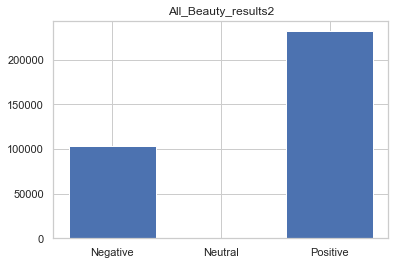

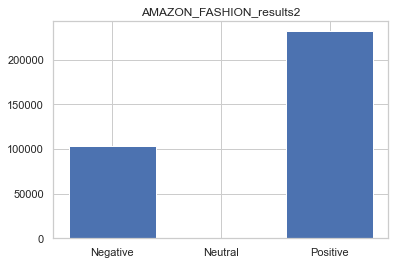

In [85]:
for result in df_results:
    y = df_results.T['class_counts'][0]
    plt.bar(cut_class_text, y)
    plt.title(result)
    plt.show()

In [86]:
df

,category_id,overall,star_sentiment,reviewText,summary,num_words,polarity,class,class_text
176525,1,1,0,Small,,1,-0.996106,0,Negative
176526,1,3,1,It's an elastic waistband with vertical strips...,"It's just ok. There is no ""tie top"" or split.",22,-0.852520,0,Negative
176527,1,5,2,"I purchased size large. I am 5'10"" with a 32""...","The length was perfect, just down to my ankles",75,0.999314,2,Positive
176528,1,5,2,Love that it is long and flowy. You can wear i...,Love that it is long and flowy,21,0.999852,2,Positive
176529,1,1,0,Hate it!! It is not as big and full. Like the...,,16,-0.999822,0,Negative
176530,1,1,0,It's a beautiful skirt but is way small. I got...,skirt not worth the money,46,-0.998091,0,Negative
176531,1,5,2,Looks like it cost more than I spent. It mana...,Absolutely beautiful and stunning little eveni...,52,-0.994881,0,Negative
176532,1,5,2,Perfect size - Beautiful purse that I used for...,Great value,21,0.999833,2,Positive
176533,1,5,2,The bag is stunning. Two separate straps for c...,The Glamourous Peacock,37,0.999731,2,Positive
176534,1,5,2,OMG! I love this purse! I was a little worri...,Perfect!,45,0.999717,2,Positive


## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df["reviewText"], test_size=0.2, random_state=42, shuffle=True)

## Save reviews to text format

In [8]:
save_dir = "data/amazon"

train_file = "Prime_Pantry.reviewText.train.txt"
test_file = "Prime_Pantry.reviewText.test.txt"

train_path = os.path.join(save_dir, train_file)
test_path = os.path.join(save_dir, test_file)

train.to_csv(train_path, header=None, index=None, sep=' ')
test.to_csv(test_path, header=None, index=None, sep=' ')

# Pipeline

In [9]:
from transformers import pipeline

In [10]:
classifier = pipeline('sentiment-analysis')

In [92]:
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
0,1.0,False,"12 11, 2015",A27BTSGLXK2C5K,B017O9P72A,Jacob M. Wessler,Alexa is not able to control my lights. If I a...,"VERY Buggy, doesn't work.",1449792000,
1,4.0,False,"12 8, 2015",A27ZJ1NCBFP1HZ,B017O9P72A,Greg,"Alexa works great for me so far, but I'm also ...",So Far So Good,1449532800,5
2,1.0,False,"12 7, 2015",ACCQIOZMFN4UK,B017O9P72A,Da-Gr8-1,Weak!!\n\nAlexa doesn't even recognize the nam...,Time waster,1449446400,11
3,2.0,False,"12 5, 2015",A3KUPJ396OQF78,B017O9P72A,Larry Russlin,Can only control one of two bulbs from one of ...,Buggy,1449273600,
4,1.0,False,"02 2, 2018",A1U1RE1ZI19E1H,B017O9P72A,Rebekah,this worked great then randomly stopped. pleas...,stopped working,1517529600,2
...,...,...,...,...,...,...,...,...,...,...
996,5.0,False,"07 6, 2017",A2Q47Z4IJPFZRW,B017OBSCOS,Jim Conrad,Although Alexa doesn't always get the right wo...,Wonderful wordsmith game,1499299200,
997,5.0,False,"07 5, 2017",A2UUS1TBJFXV2L,B017OBSCOS,Nick DeTroia,"Great game, helps with expanding vocabulary an...",Awesome game,1499212800,
998,4.0,False,"07 3, 2017",A3G90J2GEGDVFC,B017OBSCOS,Akshaya Janardhanan,Keeps everyone entertained. A few times it doe...,Fun app,1499040000,
999,2.0,False,"07 3, 2017",A2JJF4WXHFBRIT,B017OBSCOS,Condo King,Needs work. Fun when it does work.,Gets alot of the words I say wrong. I repeat o...,1499040000,


In [45]:
df[['reviewText','summary', 'overall']][:10]

,reviewText,summary,overall
0,Alexa is not able to control my lights. If I a...,"VERY Buggy, doesn't work.",1.0
1,"Alexa works great for me so far, but I'm also ...",So Far So Good,4.0
2,Weak!!\n\nAlexa doesn't even recognize the nam...,Time waster,1.0
3,Can only control one of two bulbs from one of ...,Buggy,2.0
4,this worked great then randomly stopped. pleas...,stopped working,1.0
5,Great skill,Great,5.0
6,Pretty crappy. Won&rsquo;t connect with Alexis,Returning to,1.0
7,Not happy. Can not connect to Alexa regardless.,Can not connect to ECHO,1.0
8,Can not connect a hue lights to Alexa. Linked ...,Connecting is a no go,1.0
9,"The service works with google home, but doesn'...",Does not work,1.0


In [56]:
df['summary'] + '. ' + df['reviewText']

0       VERY Buggy, doesn't work.. Alexa is not able t...
1       So Far So Good. Alexa works great for me so fa...
2       Time waster. Weak!!\n\nAlexa doesn't even reco...
3       Buggy. Can only control one of two bulbs from ...
4       stopped working. this worked great then random...
                              ...                        
996     Wonderful wordsmith game. Although Alexa doesn...
997     Awesome game. Great game, helps with expanding...
998     Fun app. Keeps everyone entertained. A few tim...
999     Gets alot of the words I say wrong. I repeat o...
1000    Poor diction. G, y, d, and n/m words won't pic...
Length: 1001, dtype: object

In [63]:
inputs = list(df['reviewText'] + '. ' + df['summary'])[:10]

In [64]:
inputs[1]

'Alexa works great for me so far, but I\'m also only controlling a single bulb at the moment. Turning on/off, changing colors and adjusting brightness are all easy and quick. That being said, I\'m expecting complications as I add more bulbs (hope for the best prepare for the worst, right?)\n\nI\'d speculate that some other users\' frustrations might stem from Alexa not recognizing their bulb or room names. After simplifying my bulb name to \'Lamp\' and listing it under a Living Room group (within the LIFx app), I\'ve been able to address it by either category pretty consistently.\n"Turn on/off living room lights."\n"Change lamp light to [color]"\n"Dim living room lights to [X]%"\n\nLike any new tech, you can expect growing pains and bugs early on. Be patient. This skill isn\'t perfect by any means, but I\'d say it\'s off to a decent start. So Far So Good'

In [65]:
sentiments = classifier(inputs)

In [66]:
# for sentence, sentiment in zip(inputs, sentiments):
#     print(f"{'+' if sentiment['label'] == 'POSITIVE' else '-'} {round(sentiment['score'], 4)}: {sentence} ")

In [67]:
df_results = pd.DataFrame(sentiments)
df_results['sentiment'] = np.where(df_results['label'] == 'POSITIVE', df_results['score'], -1.0 * df_results['score'])

cut_class = np.arange(1,6) # mimics stars, but really should be np.arange(5)
cut_class_text = ["Terrible", "Negative", "Neutral", "Positive", "Excellent"]
cut_bins = np.linspace(
    start = -1, 
    stop = 1,
    num = 6
)
cut_intervals = pd.interval_range(
    start = -1, 
    end = 1,
    periods = 5
)

df_results['interval']   = pd.cut(df_results['sentiment'], bins=cut_intervals)
df_results['class']      = pd.cut(df_results['sentiment'], bins=cut_bins, labels=cut_class)
df_results['class_text'] = pd.cut(df_results['sentiment'], bins=cut_bins, labels=cut_class_text)

In [68]:
df_results

,label,score,sentiment,interval,class,class_text
0,NEGATIVE,0.999785,-0.999785,"(-1.0, -0.6]",1,Terrible
1,POSITIVE,0.939940,0.939940,"(0.6000000000000001, 1.0]",5,Excellent
2,NEGATIVE,0.999819,-0.999819,"(-1.0, -0.6]",1,Terrible
3,NEGATIVE,0.999513,-0.999513,"(-1.0, -0.6]",1,Terrible
4,NEGATIVE,0.998790,-0.998790,"(-1.0, -0.6]",1,Terrible
5,POSITIVE,0.999876,0.999876,"(0.6000000000000001, 1.0]",5,Excellent
6,NEGATIVE,0.999337,-0.999337,"(-1.0, -0.6]",1,Terrible
7,NEGATIVE,0.999773,-0.999773,"(-1.0, -0.6]",1,Terrible
8,NEGATIVE,0.999263,-0.999263,"(-1.0, -0.6]",1,Terrible
9,NEGATIVE,0.999730,-0.999730,"(-1.0, -0.6]",1,Terrible


In [25]:
df_results['class'].value_counts(sort=False)

1    9
2    0
3    0
4    0
5    1
Name: class, dtype: int64

# Tokenizer + Model

In [151]:
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [152]:
# Store the model we want to use
MODEL_NAME = "distilbert-base-uncased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [158]:
tokenizer